## In this notebook we are going to compare the performance among
## the mentioned three concatenation methods

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os.path as osp
import statistics

import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import torch.nn.functional as F

from optimal_R import option, all_possible_concatenation
from graph_property import G_property, binning
from model.aug_GNN import augGNN
from utils import max_len_arr

/home/jiaqing/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jiaqing/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=

In [37]:
dataset = 'Cora'

In [38]:
# define train and test loop
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()

def test():
    model.eval()
    logits, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [61]:
def option():
    parser = ArgumentParser()
    parser.add_argument('--dataset', default='Cora', type=str, help='dataset')
    parser.add_argument('--multiple_dataset', default=False, type=bool, help='multiple dataset testing or not')
    parser.add_argument('--threshold', default=0.8, type=float, help='threshold')
    parser.add_argument('--task', default='getR', type=str, help='getR or getConcat')
    parser.add_argument('--aim_feature', default=1, type=int, help='graph features')
    parser.add_argument('--show_matrix', default=False, type=bool, help='show the gathered matrix')
    return parser.parse_args(args=['--dataset', 'Cora', '--multiple_dataset', 'False', '--threshold', '0.8', '--task', 'getR','--aim_feature','3','--show_matrix','False' ])

all possible concatenations:
2 features: 
[(0, 2), (0, 4), (2, 4)]
3 features: 
[(0, 2, 4)]
4 features: 
[]
all possible concatenations:
2 features: 
[(0, 2), (0, 4), (2, 4)]
3 features: 
[(0, 2, 4)]
4 features: 
[]
all possible concatenations:
2 features: 
[(0, 2), (0, 4), (2, 4)]
3 features: 
[(0, 2, 4)]
4 features: 
[]


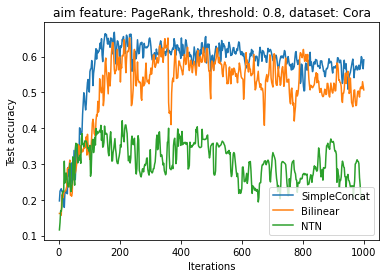

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.figure()
o = option()
methods = ['SimpleConcat', 'Bilinear', 'NTN']

for method in methods:
    o.dataset = dataset
    ans = all_possible_concatenation(o)
    min_ans_len, max_ans_len = max_len_arr(ans)

    c_index = 0
    
    # --- load dataset --- #
    path = osp.join('/home/jiaqing/桌面/Fea2Fea/data/')
    data_set = Planetoid(path, name = dataset, transform=T.NormalizeFeatures())
    data = data_set[0]
    name = r'/home/jiaqing/桌面/Fea2Fea/Result/Planetoid/' + dataset + '_property.txt'
    property_file = pd.read_csv(name, sep = '\t')
    
    # change aim feature with binning method
    data.y = np.array(property_file.iloc[:,[o.aim_feature]])
    number = len(data.y)
    data.y = binning(data.y, k = 6,data_len = number)
    #mean_acc = [[] for i in range(min_ans_len, max_ans_len+1)]
    for value in ans: # for each combination entry:
        # should transform value to list 
        data.x = np.array(property_file.iloc[:,list(value)])
        data.x = torch.tensor(data.x).float()
        data =  data.to(device)
        for i in range(1):
            model =  augGNN(input_dim = len(value), method = method).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
            t = 0
            best_val_acc = test_acc = 0 
            train_accu = []
            test_accu = []
            
            count = []
            for epoch in range(1, 3000):

                train()
                train_acc, val_acc, tmp_test_acc = test()
                if epoch%2 == 0 and epoch <= 1000:
                    count.append(epoch)
                    train_accu.append(train_acc)
                    test_accu.append(tmp_test_acc)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    test_acc = tmp_test_acc
                    t = 0

                t = t + 1
                if t > 1000:
                    break   
                log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
                #print(log.format(epoch, train_acc, best_val_acc, test_acc))
            #mean_acc[len(value) - min_ans_len].append(test_acc)
        break

    #mean_acc_ = [ sum(mean_acc[i])/len(mean_acc[i]) for i in range(len(mean_acc))]
    #mean_acc_ = [float('{:.4f}'.format(i)) for i in mean_acc_] 
    #std_acc = [statistics.stdev(mean_acc[i]) for i in range(len(mean_acc))]
    #saved.append(mean_acc_)
    #saved.append(std_acc)

    #x_axis = [i for i in range(min_ans_len, max_ans_len+1)]

    #plt.plot(count, train_accu, label=method)
    plt.plot(count, test_accu, label=method)
    
    #plt.errorbar(x_axis, mean_acc_ , yerr = std_acc, fmt='o-', elinewidth=2,capsize=4,label=dataset)
    #ax.grid(alpha=0.5, linestyle=':')
    c_index+=1

# save mean acc and std acc   
# saved = pd.DataFrame(saved)
# path =  '/home/jiaqing/桌面/Fea2Fea/Result/acc_record_'+ str(o.aim_feature) +'.txt'
# saved.to_csv(path, header = None, index = None, sep = '\t')    
plt.xlabel("Iterations")
plt.ylabel("Test accuracy")
t_label =  ['Constant','Degree','Clustering','PageRank','Aver_Path_Len']
plt.title("aim feature: {}, threshold: {}, dataset: {}".format(t_label[o.aim_feature], o.threshold, datasets[0]))
plt.legend(loc = 'lower right')
path = '/home/jiaqing/桌面/Fea2Fea/Result/pipeline/'
plt.savefig(path + 'differnt_concat_method_node_test{}.eps'.format(o.aim_feature), dpi = 400, bbox_inches='tight')
plt.show()
